## Data loading

In [20]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

def get_slice_mask_path(base_dir, patient_id):
    ### FROM https://github.com/NusLuoKe/IRCADb #TODO

    slice_path_list = []
    mask_path_list = []
    venoussystem_path_list = []
    artery_path_list = []

    patient_dicom_path = "3Dircadb1." + str(patient_id) + "/PATIENT_DICOM"
    mask_dicom_path = "3Dircadb1." + str(patient_id) + "/MASKS_DICOM/liver"
    venoussystem_dicom_path = "3Dircadb1." + str(patient_id) + "/MASKS_DICOM/venoussystem"
    artery_dicom_path = "3Dircadb1." + str(patient_id) + "/MASKS_DICOM/artery"

    
    slice_path = os.path.join(base_dir, patient_dicom_path)
    mask_path = os.path.join(base_dir, mask_dicom_path)
    venoussystem_path = os.path.join(base_dir, venoussystem_dicom_path)
    artery_path = os.path.join(base_dir, artery_dicom_path)

    for slice in os.listdir(slice_path):
        single_slice_path = os.path.join(slice_path, slice)
        if os.path.basename(single_slice_path)[0:5] == "image":
            slice_path_list.append(single_slice_path)


    for mask in os.listdir(mask_path):
        single_mask_path = os.path.join(mask_path, mask)
        if os.path.basename(single_mask_path)[0:5] == "image":
            mask_path_list.append(single_mask_path) 
    
    for venoussystem in os.listdir(venoussystem_path):
        single_venoussystem_path = os.path.join(venoussystem_path, venoussystem)
        if os.path.basename(single_venoussystem_path)[0:5] == "image":
            venoussystem_path_list.append(single_venoussystem_path) 
    
    for artery in os.listdir(artery_path):
        single_artery_path = os.path.join(artery_path, artery)
        if os.path.basename(single_artery_path)[0:5] == "image":
            artery_path_list.append(single_artery_path) 

    # argssorts the elements based on the last number
    sorted_indexes =  np.array([int(element.split('_')[-1]) for element in slice_path_list])
    sorted_indexes = sorted_indexes.argsort()

    # reorders based on the new sorting
    slice_path_list = [slice_path_list[i] for i in sorted_indexes]    
    mask_path_list = [mask_path_list[i] for i in sorted_indexes]
    venoussystem_path_list = [venoussystem_path_list[i] for i in sorted_indexes]
    artery_path_list = [artery_path_list[i] for i in sorted_indexes]

    return slice_path_list, mask_path_list, venoussystem_path_list, artery_path_list


## Cropping

In [37]:
def load_Dicom(file_list):
    files = []

    for file in file_list:
        files.append(pydicom.dcmread(file).pixel_array)

    return np.array(files)


def mask_slice_segmentation(slices, masks, segmentations):
    
    none_empty_slices_index = []
    # masks all slices
    for i in range(slices.shape[0]):
        slices[i,:,:] = np.where(masks[i,:,:] == 255, slices[i,:,:], 0) 
        masks[i,:,:] = np.where(masks[i,:,:] == 255, masks[i,:,:], 0) 
        segmentations[i,:,:] = np.where(masks[i,:,:] == 255, segmentations[i,:,:], 0) 

        if np.sum(slices[i,:,:])!= 0:
            none_empty_slices_index.append(i)

    # stores the width and height of the mask
    axis0_first_global = np.Inf
    axis0_last_global = 0
    axis1_first_global = np.Inf
    axis1_last_global = 0

    # Calculates the width and height of the mask
    for mask in masks:
        nonzeros =  np.nonzero(mask)

        # stops if there is no mask
        if len(nonzeros[0]) == 0 or len(nonzeros[1]) == 0:
            continue

        axis0_first = np.min(nonzeros[0])
        axis0_last = np.max(nonzeros[0])
        axis1_first = np.min(nonzeros[1])
        axis1_last = np.max(nonzeros[1])

        if axis0_first_global > axis0_first:
            axis0_first_global = axis0_first
        
        if axis0_last_global < axis0_last:
            axis0_last_global = axis0_last

        if axis1_first_global > axis1_first:
            axis1_first_global = axis1_first
        
        if axis1_last_global < axis1_last:
            axis1_last_global = axis1_last

    # slices to the width and height of the mask, and drops empty slices
    slices = slices[none_empty_slices_index,axis0_first_global:axis0_last_global,axis1_first_global:axis1_last_global]
    masks = masks[none_empty_slices_index,axis0_first_global:axis0_last_global,axis1_first_global:axis1_last_global]
    segmentations = segmentations[none_empty_slices_index,axis0_first_global:axis0_last_global,axis1_first_global:axis1_last_global]



    return slices, masks, segmentations



## Visualization

In [46]:

slice_path_list, mask_path_list, venoussystem_path_list, artery_path_list = get_slice_mask_path("/Users/christian/Downloads/3Dircadb1", patient_id=1)

slice_list = load_Dicom(slice_path_list)
mask_list = load_Dicom(mask_path_list)
venoussystem_list = load_Dicom(venoussystem_path_list)
artery_list = load_Dicom(artery_path_list)
segmentation_list =  np.where(venoussystem_list + artery_list != 0, 1,0)

slices, masks, segmentations = mask_slice_segmentation(slice_list, mask_list, segmentation_list)

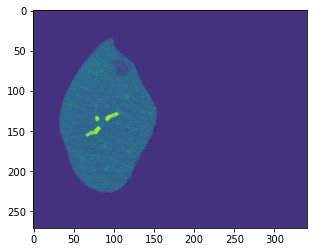

In [47]:
image_number = 23

PATIENT_DICOM = slices[image_number,:,:]
MASKS_DICOM = segmentations[image_number,:,:]

DICOM = (1*PATIENT_DICOM)/np.max(PATIENT_DICOM) + MASKS_DICOM

plt.imshow(DICOM)

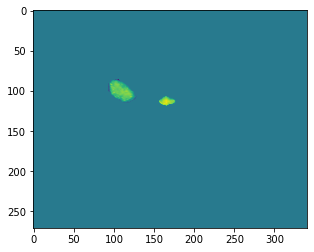

In [48]:

fig, ax = plt.subplots()
ims = []
for i in range(len(slices)):

    PATIENT_DICOM = slices[i,:,:]
    MASKS_DICOM = segmentations[i,:,:]
    DICOM = PATIENT_DICOM/np.max(PATIENT_DICOM) + MASKS_DICOM

    im = ax.imshow(DICOM, animated=True)
    if i == 0:
        ax.imshow(DICOM)  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save("slices.mp4")

In [36]:
print(np.unique(slice_list[1,:,:]))

[0]
